# **Report Code**

### **Imports**

In [26]:
import diplib as dip
import numpy as np
import matplotlib.pyplot as plt
from typing import Union

Critical size: (50, 2500) | Amount of found points: 6


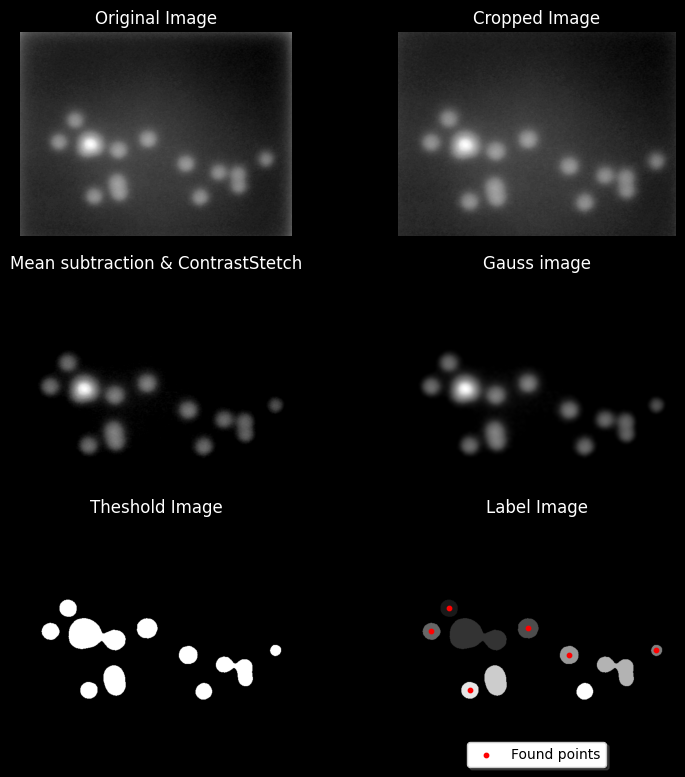

In [20]:
def load_imgs(image: int, density: int) -> dip.Image:
    """
    Function to load the recorded frames
    
    Args:
        - image: the image number, 1 or 2
        - density: the density setting, 20 or 50

    Returns:
        - dip.Image object
    """
    path = f'data2/image{image}_100_{density}_10.ics'
    imgs = dip.ImageReadICS(path)
    
    return imgs

def plot(
    image: dip.Image,
    image_array: np.array,
    image_mean_sub: dip.Image,
    image_gauss: dip.Image,
    image_thres: dip.Image,
    image_label: dip.Image,
    critical_points: np.array
) -> None:
    """
    Function to plot all processing steps. Used to develop
    the processing and center of mass extraction algorithm.

    Args:
        - image: the original frame
        - image_array: the cropped frame
        - image_mean_sub: the frame where the mean is subtracted
            and a ContrastStretch is applied
        - image_gauss: a gaussian filter over the image_mean_sub frame
        - image_thres: a threshold filter over image_gauss
        - image_label: the diplib label function result of image_thres
        - critical_points: an array of all the found centers of mass
    """
    fig, ax = plt.subplots(3, 2, figsize=(9, 9), facecolor='black')
    c = (0,0)
    ax[c[0],c[1]].imshow(np.asarray(image), cmap='gray')
    ax[c[0],c[1]].set_title('Original Image', c='white')
    ax[c[0],c[1]].axis('off')

    c = (0,1)
    ax[c[0],c[1]].imshow(image_array, cmap='gray')
    ax[c[0],c[1]].set_title('Cropped Image', c='white')
    ax[c[0],c[1]].axis('off')

    c = (1,0)
    ax[c[0],c[1]].imshow(np.asarray(image_mean_sub), cmap='gray')
    ax[c[0],c[1]].set_title('Mean subtraction & ContrastStetch', c='white')
    ax[c[0],c[1]].axis('off')

    c = (1,1)
    ax[c[0],c[1]].imshow(np.asarray(image_gauss), cmap='gray')
    ax[c[0],c[1]].set_title('Gauss image', c='white')
    ax[c[0],c[1]].axis('off')

    c = (2,0)
    ax[c[0],c[1]].imshow(np.asarray(image_thres), cmap='gray')
    ax[c[0],c[1]].set_title('Theshold Image', c='white')
    ax[c[0],c[1]].axis('off')

    c = (2,1)
    ax[c[0],c[1]].imshow(np.asarray(image_label), cmap='gray')
    ax[c[0],c[1]].scatter(critical_points[:,0], critical_points[:,1], c='r', s=10, label='Found points')
    ax[c[0],c[1]].set_title('Label Image', c='white')
    ax[c[0],c[1]].axis('off')
    ax[c[0],c[1]].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

    plt.show()

def get_critical_points(
    frame: dip.Image,
    crit_min_max: tuple=(50,2500),
    sigma: int=2,
    crop: bool=True
) -> list:
    """
    Function to extract the centers of mass of a frame 
    and return them in a list, without any plots. 
    Used to reconstruct the images

    Args:
        - frame: the frame to be processed
        - crit_min_max: a tuple with the minimum and maximum allowed
            blob size
        - sigma: the setting for the smoothing effect of the gaussian
            filter
        - crop: whether the frame is cropped or not

    Returns:
        - list with all the found coordinates of the centers
            of mass
    """
    image = frame.Squeeze()

    # Crop the image if wanted
    if crop:
        cropped_image = image[20:-20,20:-20]
    else:
        cropped_image = image

    image_array = np.asarray(cropped_image)

    # Subtract the mean from the image and apply the ContrastStretch filter
    image_mean_sub = dip.ContrastStretch(dip.Image((image_array - np.mean(image_array)).clip(min=0)), lowerBound=80)

    image_gauss = dip.Gauss(dip.Image(image_mean_sub), sigmas=[sigma]) # Apply the gaussian filter
    image_thres = dip.IsodataThreshold(image_gauss) # Apply the threshold filter
    image_label = dip.Label(image_thres) # Get the label image

    # Get all the sizes and coordinates of the centers of mass
    measurement = dip.MeasurementTool.Measure(label=image_label, grey=cropped_image.Squeeze(), features=['Gravity', 'Size'])

    # Extract the coordinates of the measurments and filter on sizes
    critical_points = [measurement['Gravity'][i]
                        for i in range(1,measurement.NumberOfObjects())
                        if measurement['Size'][i][0] < crit_min_max[1] 
                        and measurement['Size'][i][0] > crit_min_max[0]]
    
    return critical_points

def analyse_image_with_plot(
    image_num: int,
    density: int,
    frame: int,
    crit_min_max: tuple=(50,2500),
    sigma: int=2,
    crop: bool=True
) -> None: 
    """
    Function to process a frame and extract the centers of mass
    with all processing steps plotted. Used to develop the
    processing algorithm.

    Args:
        - image_num: which image to use
        - density: which density setting to use
        - frame: the frame to be processed
        - crit_min_max: a tuple with the minimum and maximum allowed
            blob size
        - sigma: the setting for the smoothing effect of the gaussian
            filter
        - crop: whether the frame is cropped or not
    """
    image = load_imgs(image_num, density)[:,:,frame].Squeeze()

    # Crop the image if wanted
    if crop:
        cropped_image = image[20:-20,20:-20]
    else:
        cropped_image = image

    image_array = np.asarray(cropped_image)
    
    # Subtract the mean from the image and apply the ContrastStretch filter
    image_mean_sub = dip.ContrastStretch(dip.Image((image_array - np.mean(image_array)).clip(min=0)), lowerBound=80)

    image_gauss = dip.Gauss(dip.Image(image_mean_sub), sigmas=[sigma]) # Apply the gaussian filter
    image_thres = dip.IsodataThreshold(image_gauss) # Apply the threshold filter
    image_label = dip.Label(image_thres) # Get the label image

    # Get all the sizes and coordinates of the centers of mass
    measurement = dip.MeasurementTool.Measure(label=image_label, grey=cropped_image.Squeeze(), features=['Gravity', 'Size'])

    # Extract the coordinates of the measurments and filter on sizes
    critical_points = np.array([measurement['Gravity'][i]
                                for i in range(1,measurement.NumberOfObjects())
                                if measurement['Size'][i][0] < crit_min_max[1] 
                                and measurement['Size'][i][0] > crit_min_max[0]])

    print(f'Critical size: {crit_min_max} | Amount of found points: {len(critical_points)}')
    plot(
        image,
        image_array,
        image_mean_sub,
        image_gauss,
        image_thres,
        image_label,
        critical_points
    )

# Manually determined dictionary used to analyse only the
# frames where the blobs are in the picture
frame_range = {
    1:{
        20: (20, 1490),
        50: (0, 1580)
    },
    2:{
        20: (7, 1647),
        50: (2, 1696)
    }
}

analyse_image_with_plot(image_num=1, density=20, frame=25, crit_min_max=(50,2500), crop=True)

In [21]:
image_num = 2
density = 50

imgs = load_imgs(image_num,density)
max_frames = 100
frames = imgs.Sizes()[2]
coordinates = []

print(f'Image: {image_num} | Density: {density}| Frames: {frames}')

# Loop through recorded frames
for frame_num in range(frame_range[image_num][density][0], frame_range[image_num][density][1]):
    # Get centers of mass
    coordinates.append(get_critical_points(frame=imgs[:,:,frame_num]))

# Reconstruct image
rc = dip.Image(sizes=[640, 480], dt='SFLOAT')
rc.Fill(0)

for i in coordinates:
    for jj in i:
        rc[round(jj[0]), round(jj[1])] = rc[round(jj[0]), round(jj[1])][0] + 1.0

dip.viewer.Show(rc)

Image: 2 | Density: 50| Frames: 1712


Critical size: (50, 2500) | Amount of found points: 18


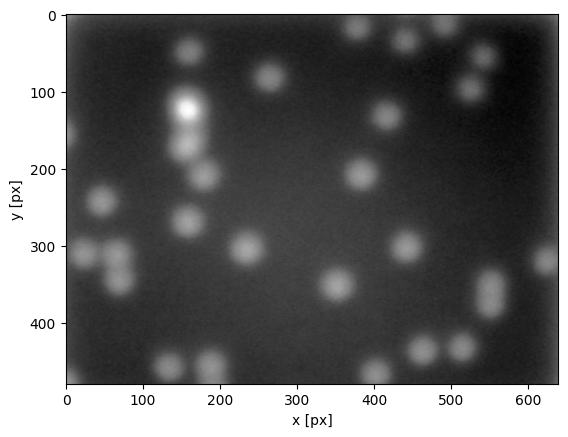

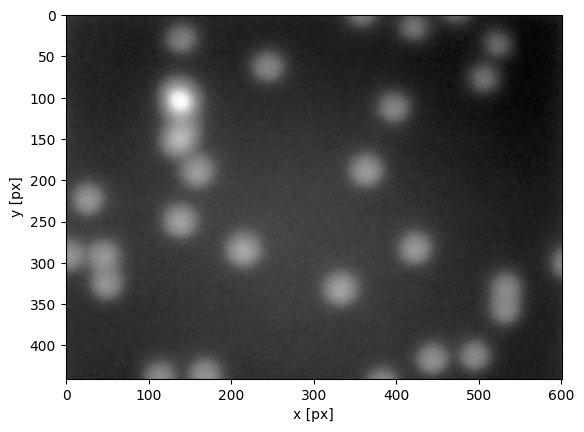

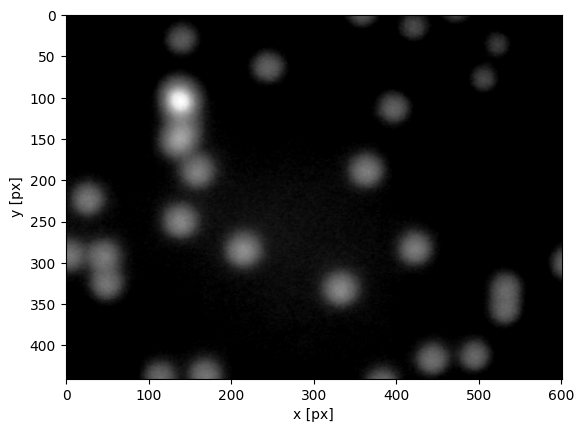

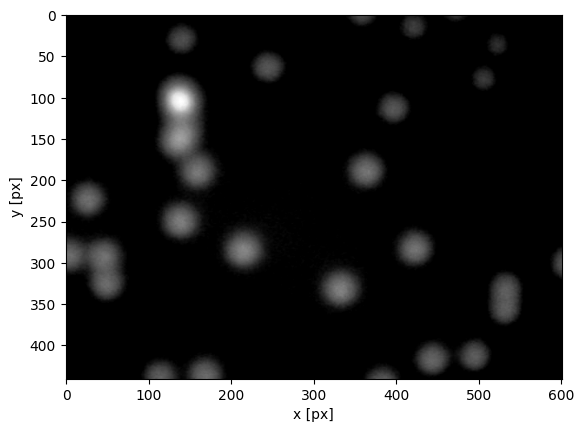

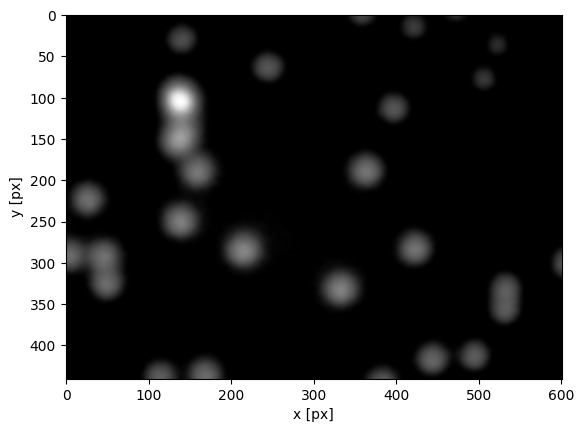

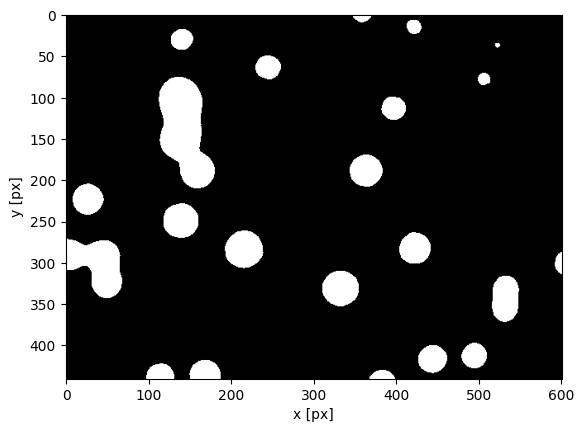

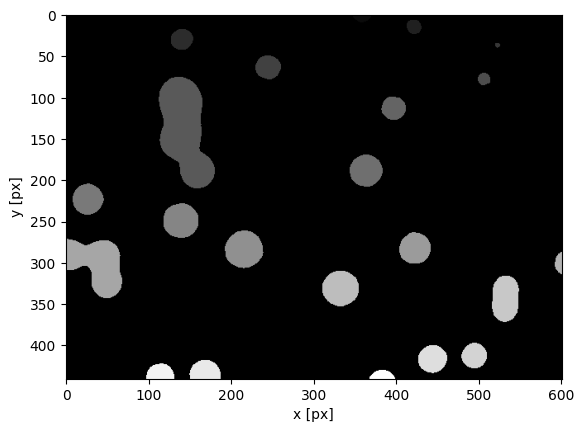

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


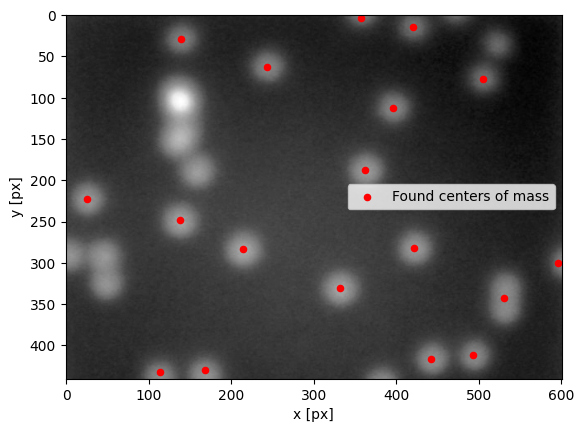

In [28]:
frame = 50
image = load_imgs(image_num, density)[:,:,frame].Squeeze()
critical_size = (50, 2500) # (minimun blob size, maximum blob size)
sigma = 2

cropped_image = image[20:-20,20:-20] # Crop the image
image_array = np.asarray(cropped_image)

image_mean_sub = dip.Image((image_array - np.mean(image_array)).clip(min=0)) # Subtract the mean value from the image
image_contrast = dip.ContrastStretch(image_mean_sub, lowerBound=80) # Apply a ContrastStretch filter

image_gauss = dip.Gauss(image_contrast, sigmas=[sigma]) # Apply a Gauss filter
image_thres = dip.IsodataThreshold(image_gauss) # Get the threshold image
image_label = dip.Label(image_thres) # Get the label image

measurement = dip.MeasurementTool.Measure(label=image_label, grey=cropped_image.Squeeze(), features=['Gravity', 'Size']) # Find all center of masses

# Extract coordinates of measurements with a size filter
critical_points = np.array([measurement['Gravity'][i]
                            for i in range(1,measurement.NumberOfObjects())
                            if measurement['Size'][i][0] < critical_size[1] 
                            and measurement['Size'][i][0] > critical_size[0]])

print(f'Critical size: {critical_size} | Amount of found points: {len(critical_points)}')

# Plot and save all processing steps
def plot_save(
    image: Union[dip.Image, np.array],
    title: str
) -> None:
    """
    Function to create and save a plot of an image,
    plots are saved in the eps format.

    Args:
        - image: the image to be plotted
        - title: used to create the filename
    """
    plt.figure()
    plt.imshow(np.asarray(image), cmap='gray')
    plt.xlabel('x [px]')
    plt.ylabel('y [px]')
    plt.savefig('plots/'+title+'.eps', format='eps')
    plt.show()

plot_save(image, 'original')
plot_save(cropped_image, 'cropped')
plot_save(image_mean_sub, 'mean_sub')
plot_save(image_contrast, 'contrast')
plot_save(image_gauss, 'gauss')
plot_save(image_thres, 'threshold')
plot_save(image_label, 'label')

plt.figure()
plt.imshow(np.asarray(cropped_image), cmap='gray')
plt.scatter(critical_points[:,0], critical_points[:,1], c='r', s=20, label='Found centers of mass')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.legend()
plt.savefig('plots/measurements.eps', format='eps')
plt.show()